In [66]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [67]:
dc=pd.read_csv('doctor_information.csv')
pt=pd.read_csv('patient_information.csv')
apt=pd.read_csv('appointments.csv')

In [68]:
dc.describe()

,ID,Age,Type,Experience,Hospital Location,Patients in Queue,Patients Seen in Lifetime
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,7760.760210,54.933190,50.453050,14.971910,950.023910,15.537560,5505.415220
std,4184.189546,14.751454,28.879966,8.943474,29.193538,8.674896,2597.791948
min,500.000000,30.000000,1.000000,0.000000,900.000000,1.000000,1000.000000
25%,4132.000000,42.000000,25.000000,7.000000,925.000000,8.000000,3258.000000
50%,7771.000000,55.000000,50.000000,15.000000,950.000000,16.000000,5504.000000
75%,11391.250000,68.000000,76.000000,23.000000,975.000000,23.000000,7753.000000
max,15000.000000,80.000000,100.000000,30.000000,1000.000000,30.000000,10000.000000


In [69]:
pt.describe()

,ID,Age,Gender,Health Condition,Hospital Location,Preferred Doctor Type,Last Appointment
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2997.029940,53.861420,1.501420,50.704980,950.039840,50.557780,183.981020
std,1158.672088,21.060809,0.500003,28.845212,29.068846,28.957266,105.450938
min,1000.000000,18.000000,1.000000,1.000000,900.000000,1.000000,1.000000
25%,1991.000000,36.000000,1.000000,26.000000,925.000000,26.000000,92.000000
50%,2992.000000,54.000000,2.000000,51.000000,950.000000,51.000000,185.000000
75%,4000.250000,72.000000,2.000000,76.000000,975.000000,76.000000,276.000000
max,5000.000000,90.000000,2.000000,100.000000,1000.000000,100.000000,365.000000


In [70]:
apt.describe()

,AppointmentID,PatientID,DoctorID,AppointmentDate,Rating
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,2472.530391,2953.258321,7648.138929,182.993488,7.039074
std,1423.445547,1156.271622,4121.384723,103.058053,2.018361
min,2.000000,1001.000000,506.000000,1.000000,4.000000
25%,1244.250000,1964.000000,4067.250000,96.250000,5.000000
50%,2491.000000,2947.000000,7751.500000,184.000000,7.000000
75%,3634.500000,3900.000000,11302.000000,271.000000,9.000000
max,5000.000000,4996.000000,14994.000000,365.000000,10.000000


In [71]:
# find if every appointment has a doctor and a patient whose information is available

apt['DoctorID'].isin(dc['ID']).value_counts()
apt['PatientID'].isin(pt['ID']).value_counts()

PatientID
True    1382
Name: count, dtype: int64

In [72]:
docs=np.array(dc['ID'])
pts=np.array(pt['ID'])

In [73]:
docs[0]
pts[0]

2335

In [74]:
# use this to create x values for the model which will be a list of lists of the form [[doctor information],[patient information]]

doctor_info = []
patient_info = []

for i in range(len(apt)):
    inf_doc = dc[dc['ID'] == apt['DoctorID'][i]]
    inf_pt = pt[pt['ID'] == apt['PatientID'][i]]
    inf_doc = inf_doc.values[0]                         #there is a problem here
    inf_pt = inf_pt.values[0]                            #there is a problem here
    doctor_info.append(inf_doc)
    patient_info.append(inf_pt)

doctor_info = np.array(doctor_info)
patient_info = np.array(patient_info)

y = apt['Rating'].values.tolist()

In [75]:
# normalize the data

doctor_info = (doctor_info - np.mean(doctor_info))/np.std(doctor_info)
patient_info = (patient_info - np.mean(patient_info))/np.std(patient_info)

In [76]:
doctor_info[0]
patient_info[0]

array([ 1.01993402, -0.49551902, -0.55012994, -0.4918783 ,  0.30726151,
       -0.53010594, -0.385387  ])

In [77]:
# create training and testing data

train_size = int(0.8*len(doctor_info))
test_size = len(doctor_info) - train_size

train_doctor_info = doctor_info[:train_size]
train_patient_info = patient_info[:train_size]
train_y = y[:train_size]

test_doctor_info = doctor_info[train_size:]
test_patient_info = patient_info[train_size:]
test_y = y[train_size:]

In [78]:
patient_model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
])

doctor_model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(128,activation='relu'),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dense(16,activation='relu'),
])

In [79]:
@tf.function
def dot_product(x1,x2):
    y_net=[]
    print(x1)
    for i in range(len(x1)):
        y_net.append(tf.tensordot(x1[i],x2[i],axes=1))
    print(y_net)
    return y_net

In [80]:
# custom training loop

steps=len(train_doctor_info)//32

loss_fn=tf.keras.losses.MeanSquaredError()
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)


# x values batched into 32

batch_size=32
epochs=10

for epoch in range(epochs):
    print('Start of epoch %d' %(epoch,))
    for step in range(steps):
        x1=train_patient_info[step*batch_size:(step+1)*batch_size]
        x2=train_doctor_info[step*batch_size:(step+1)*batch_size]
        y_batch=train_y[step*batch_size:(step+1)*batch_size]
        with tf.GradientTape() as tape:
            patient_output=patient_model(x1)
            doctor_output=doctor_model(x2)
            # transpose doctor_output to get a column vector
            y_pred=dot_product(patient_output,doctor_output)
            loss_value=loss_fn(y_batch,y_pred)
        grads=tape.gradient(loss_value,patient_model.trainable_weights+doctor_model.trainable_weights)
        optimizer.apply_gradients(zip(grads,patient_model.trainable_weights+doctor_model.trainable_weights))
        if step%10==0:
            print('Training loss (for one batch) at step %s: %s' %(step,float(loss_value)))
            print('Seen so far: %s samples' %((step+1)*batch_size))
        if loss_value<0.01:
            break
    

Start of epoch 0
Tensor("x1:0", shape=(32, 16), dtype=float32)
[<tf.Tensor 'Tensordot:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_1:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_2:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_3:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_4:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_5:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_6:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_7:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_8:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_9:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_10:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_11:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_12:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_13:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_14:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_15:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_16:0' shape=() dtype=float32>, <tf.Tensor 'Tensordot_17:0' shape=() dtype=floa

In [81]:
def dot_product2(x1,x2):
    y_pred=[]
    for i in range(len(x1)):
        y_pred.append(tf.tensordot(x1[i],x2[i],axes=1))
    return y_pred

In [82]:
# test the model

patient_output=patient_model(test_patient_info)
doctor_output=doctor_model(test_doctor_info)

y_pred=dot_product2(patient_output,doctor_output)

In [83]:
y_pred=np.array(y_pred)

In [84]:
y_pred

array([7.0936637, 5.9423556, 7.013834 , 6.178176 , 7.0954375, 6.9402404,
       6.5813456, 6.450128 , 7.106942 , 6.64828  , 7.753042 , 6.174361 ,
       7.2323956, 6.920455 , 7.7167196, 6.4974422, 6.8573065, 6.879712 ,
       6.441144 , 5.886805 , 7.1701517, 6.306383 , 7.399083 , 6.2722716,
       6.962673 , 7.1423182, 8.598987 , 8.42417  , 6.393898 , 5.920126 ,
       6.2719655, 6.739298 , 6.6514397, 7.1177797, 6.131916 , 6.4969115,
       6.285721 , 6.497884 , 7.6752987, 6.076471 , 6.419817 , 8.850069 ,
       6.6430917, 6.800664 , 7.388626 , 8.187049 , 6.824484 , 6.5391417,
       7.7329187, 6.3544407, 6.809828 , 7.3813944, 7.0013895, 6.30884  ,
       6.306816 , 6.8212347, 6.4499044, 6.44724  , 6.8364716, 6.3001127,
       6.989134 , 7.070337 , 6.79504  , 7.1972733, 6.2667384, 6.27128  ,
       5.7295485, 7.5865154, 7.2672215, 6.487294 , 6.755783 , 7.487444 ,
       6.8103676, 6.499963 , 7.133534 , 6.953489 , 7.555614 , 6.515587 ,
       6.333765 , 6.272478 , 6.2751036, 7.860671 , 

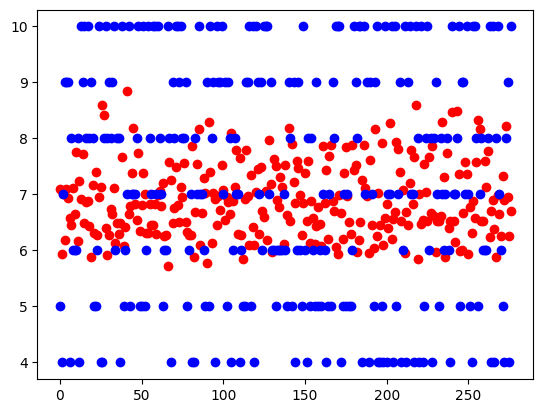

In [85]:
plt.scatter(range(len(test_y)),y_pred,color='red')
plt.scatter(range(len(test_y)),test_y,color='blue')